# Selecting feature for model using some math and backward elimination

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math 

%matplotlib inline

In [2]:
df = pd.read_csv('../df.csv')

In [3]:
df.head()

,season,title,rating,votes,double,episode,votes_norm,month,writer_B.J._Novak,writer_Mindy_Kaling,...,whispering,screaming,singing,applause,accent,crying,smiling,sigh,kiss,one
0,1,Pilot,7.4,7006,0,1,0.009148,3,0,0,...,0,1,1,0,0,1,0,1,0,1
1,1,Diversity Day,8.3,6902,0,2,0.009012,3,1,0,...,0,0,0,0,3,1,0,0,0,1
2,1,Health Care,7.7,5756,0,3,0.007516,4,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,The Alliance,8.0,5579,0,4,0.007285,4,0,0,...,2,1,1,0,0,0,0,0,1,1
4,1,Basketball,8.4,6183,0,5,0.008073,4,0,0,...,0,0,3,2,0,0,0,0,0,1


In [4]:
def RMSE(y, y_pred):
    SME = sum((y - y_pred)**2)
    
    return round(math.sqrt(SME/len(y)),3)

In [5]:
import statsmodels.formula.api as smf

def linear_regression(train, test, model_features,weights=None):
    formula = 'rating ~ '

    for value in model_features:
        if value != 'rating':
            formula += value + " + "

    formula = formula[:-2]

    print(formula)
    print()
    
    if weights is not None:
        model = smf.ols(formula, data=train, weights=weights)
    else:
        model = smf.ols(formula, data=train)
        
    results = model.fit()
    
    print(results.summary())


    prediction = results.predict(test[model_features])

    fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
    sns.scatterplot(x=test.rating.values, y=prediction.values, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction.values)}')
    sns.lineplot(x=[7,8,9], y=[7,8,9], ax=ax[0])
    
    sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
    sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')
    
    return results

## data splitting

In [7]:
characters_words_total = [word for word in df.columns if '_words_total' in word]

In [8]:
from sklearn.model_selection import train_test_split

to_drop = ['title','season','episode','votes','votes_norm','month'] + characters_words_total
df_model = df.drop(columns=to_drop, axis=1)

train, test = train_test_split(df_model, test_size=0.30, shuffle=True, random_state=1)

[Text(0.5, 1.0, 'Test dataset')]

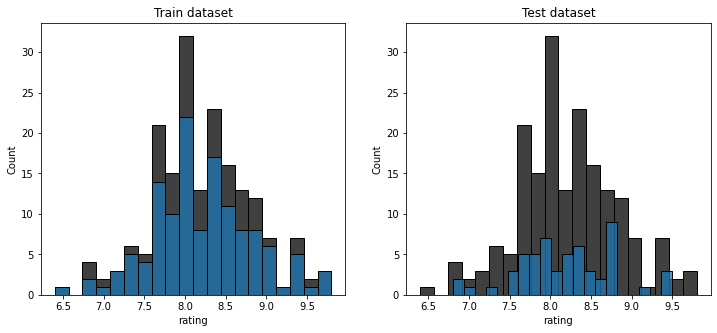

In [9]:
fig, ax = plt.subplots(figsize=(12,5),nrows=1, ncols=2)
sns.histplot(df.rating,bins=20, ax=ax[0],color='black')
sns.histplot(train.rating,bins=20, ax=ax[0]).set(title='Train dataset')
sns.histplot(df.rating,bins=20, ax=ax[1],color='black')
sns.histplot(test.rating,bins=20, ax=ax[1]).set(title='Test dataset') 


In [10]:
x_train = train.drop(columns='rating', axis=1)
y_train = train.rating

x_test = test.drop(columns='rating', axis=1)
y_test = test.rating

select all features

In [11]:
all_features = x_train.columns.values
len(all_features)

306

###  keep features, which appears more than in half episodes

number of episodes with low rating

In [12]:
len(train[train.rating < train.rating.mean()])

70

In [13]:
delete = []
for col in all_features:
    appearance = len(train[train[col] != 0])
    
    if appearance < 60:
        delete.append(col)

In [14]:
len(delete)

268

In [15]:
model_features_1 = [word for word in all_features if word not in delete]
len(model_features_1)

38

### delete features with low variance

In [16]:
from sklearn.feature_selection import VarianceThreshold

In [17]:
normalized_df = x_train[model_features_1] / x_train[model_features_1].mean()

normalized_df.var().sort_values(ascending=True)[:10]

one                   0.000000
words                 0.069520
dialog_mean_length    0.070831
number_of_dialog      0.129672
Jim_words             0.213933
Dwight_words          0.285825
Pam_words             0.308637
Michael_words         0.480687
office                0.667824
love                  0.691307
dtype: float64

In [18]:
vt = VarianceThreshold(threshold=.1)

_ = vt.fit(normalized_df)
mask = vt.get_support()

In [19]:
df_for_model = x_train[model_features_1].copy(deep=True)
df_for_model = df_for_model.loc[:,mask]

In [20]:
model_features_2 = df_for_model.columns.values

In [22]:
len(model_features_2)

35

what was deleted

In [21]:
[word for word in model_features_1 if word not in model_features_2 ]

['words', 'dialog_mean_length', 'one']

### backward elimination

In [25]:
def backward_elimination(train, features, treshold=0.05):
    max_p = 1
    
    while max_p > treshold:
#         print()
#         print(len(features), max_p)
        
        formula = 'rating ~ '
        for value in features:
            formula += value + " + "
        
        formula = formula[:-2]

        
        model = smf.ols(formula, data=train)
        results = model.fit()
        
        max_p = max(results.pvalues)
        
        if max_p > treshold:
            
            delete = []
            for col in features:
                if abs(results.pvalues[col] - max_p) <= 0.0000001:
                    delete.append(col)
                    
            features = [word for word in features if word not in delete]

        if len(features) == 0:
            break

    return features
    

In [26]:
new_features = backward_elimination(train, model_features_2, treshold=0.1)
new_features

['Dwight_words',
 'Andy_words',
 'Erin_words',
 'Meredith_words',
 'Jim_about_Dwight',
 'number_of_dialog']

rating ~ Dwight_words + Andy_words + Erin_words + Meredith_words + Jim_about_Dwight + number_of_dialog 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     10.72
Date:                Fri, 04 Feb 2022   Prob (F-statistic):           1.46e-09
Time:                        12:33:38   Log-Likelihood:                -96.059
No. Observations:                 130   AIC:                             206.1
Df Residuals:                     123   BIC:                             226.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------

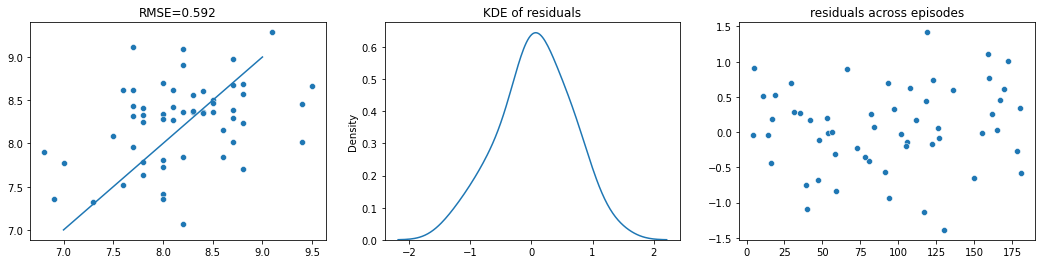

In [27]:
res = linear_regression(train, test, new_features)

In [28]:
res.params.sort_values(ascending=False)

Intercept           7.985390
Jim_about_Dwight    0.162460
Meredith_words      0.084192
number_of_dialog    0.009269
Dwight_words       -0.013184
Andy_words         -0.024990
Erin_words         -0.061501
dtype: float64